In [1]:
'''''
This python notebook was created with the intent of teaching 
WaveShow users how to use the software and change its parameters
so the user has the best experience. Sections of the code will be
broken up with instructions and descriptions similar to this one 
wherever instrutions and parameters are present. Please do not
change code where there are not instructions such as these.
'''''

# import needed libraries (Do not change)
import numpy
import math
import wave
import sys 
import pygame
from pygame.locals import *

'''''
The section below is titled "constants". Here you will find 
parameters that will determine the number of bars, height of each 
individual bar, the width of each bar as well as the frame rate in
that the visualizer will play in. 

NOTE: Changing the number, height, or width parameter will not only change the
quanitity of bars on your screen but will also change size of the
screen and the smoothing of the bars having an effect on 
visualization.
'''''

# Constants (can be changed)
number = 1000                    # number of bars
height = 600                     # height of bars
width = 2                        # width of bars
fps = 15                         # frames per second.


file_name = sys.argv[0]          # command line argument that retrives script being executed
status = 'stopped'               # current playback status
fpsclock = pygame.time.Clock()   # pygame clock object that controls frame rate.

pygame.init()                    # Initializes the pygame library                    
pygame.mixer.init()              # Initializes the pygame mixer module which works with sounds

'''''
The section below includes lines of code that allow for the 
changing of captions, font and font size, but most importantly 
the music file that you want to play. 

By changing the caption you can change the name that prints at the
top of the window. To change the font to another of your choosing, 
by typing in the 'pygame.font.get_fonts()' command in a new kernel. 
You can also change font size in the same line. This font displays 
the file path to the window launcher and a stopwatch that will stop 
counting once the music file reaches the end. Lastly, you can change 
the music to one of your choosing. As of now, the placeholder audio 
file is Fur Elize by Mozart.

NOTE: THE AUDIO FILE MUST BE IN A WAV FORMAT FOR WAVESHOW TO PLAY.
IF YOU USE ANY OTHER AUDIO FORMAT THE SYSTEM WILL NOT WORK. THE 
AUDIO WILL NOT PLAY AND THE VISUALIZER WILL NOT WORK.
'''''

# What appears on your display (can be changed)
screen = pygame.display.set_mode([number * width, 50 + height])   # pygame window size which is dependent on our constants
pygame.display.set_caption('WaveShow')                            # creates the title of the window
font = pygame.font.SysFont('Arial', 20)                           # ont style and size
pygame.mixer.music.load("Fur_Elise02.wav")                        # loads music file of your choosing. Make sure it's a wav file
#Do_I_Wanna_Know.wav
#born_to_run.wav

# Playback data (Do not change)
pygame.mixer.music.play()                                         # Begins playing the loaded music
pygame.mixer.music.set_endevent()                                 # Sets an event to be triggered when playback ends
status = "Playing"                                                # Current status

'''''
Make sure that the line that read "f = wave.open()" has the same 
audio file as the one above and that it is followed by ',rb' inside
the parentheses. This block of code reads your wav file and stores it
as a numpy array which is needed for showing the sound wave.
'''''

#process wave data (ONLY change first line)                      
f = wave.open("Fur_Elise02.wav", 'rb')                           # Opens wav file 
params = f.getparams()                                           # Retrieves parameters from the file
nchannels, sampwidth, framerate, nframes = params[:4]            # Unpacks those parameters
str_data = f.readframes(nframes)                                 # Reads the audio data from file as a string
f.close()                                                        # Closes the file
wave_data = numpy.fromstring(str_data, dtype = numpy.short)      # Converts string into a 16-bit numpy array with each element in the array representing the amplitude at a point in time
wave_data.shape = -1, 2                                          # Reshapes array into a 2D array with two columns.
wave_data = wave_data.T                                          # Inverts the array so that each row corresponds to a channel and each column to a point in time.

num = nframes                                                    # variable containing parameters to be used later


'''''
The smooth_waveform function in the provided code is a low-pass 
filter that smooths a given audio waveform using a simple 
recursive formula. The 'alpha' term is the smoothing parameter 
which should be kept below 0.5 for smoothing of the waves
to occur. 

NOTE: I reccommend playing with the 'scaling_factor' line as it is
resposible for the height of the waves and adjusting that parameter
can lead to some fun results.
'''''

# Numerical Softening Using low-pass filter (ONLY change alpha between 0.0-0.5)
def smooth_waveform(audio_segment, alpha=0.1):                            # 'audio_segment'represents the amplitude/time. 'alpha' is a low-pass filter which is to be kept at or below 0.5 for optimal smoothing. A smaller alpha will result in better smoothing.
    smoothed_data = [audio_segment[0]]                                    # List that will store smoothed values

    for i in range(1, len(audio_segment)):                                # Function starts with the first value of the input audio_segment and iterates through the rest of the values. For each value, it calculates a new smoothed value based on the previous smoothed value and the current audio segment value
        smoothed_value = alpha * smoothed_data[-1] + (1 - alpha) * audio_segment[i]
        smoothed_data.append(smoothed_value)

    return smoothed_data

# Visualizer (ONLY change 'scaling factor')
def Visualizer(nums):
    num = int(nums)                                                       # This parameter represents the current position in the audio file, and it is converted to an integer (num) for further processing.
    audio_segment = wave_data[0][nframes - num:nframes - num + number]    # Variable that extracts a segment of the audio waveform (wave_data[0]) based on the current position (num) and the specified number of bars (number)

    # Smooth the waveform using a low-pass filter
    smoothed_data = smooth_waveform(audio_segment)                        #  function, which applies a low-pass filter to reduce high-frequency noise in the waveform.

    # Decrease the height by multiplying with a scaling factor (e.g., 0.5)
    scaling_factor = 0.1                                                  # Applied to the smoothe data to control height of the bars 
    scaled_data = [min(height, int(i * height * scaling_factor / 400)) for i in smoothed_data]   # Sets the height of the bars
    draw_bars(scaled_data)                                                # Uses the scaled data to render the bars on the screen

# Visualizer status (Do not change)
def vis(status):                                                          # status: parameter that represents the current playback status, which is either: "stopped," "paused," or "playing."
    global num
    if status == "stopped":                                               # num is reset to (nframes). This indicates that the visualization should start from the beginning when the playback is stopped.
        num = nframes
        return
    elif status == "paused":                                              # The visualization updates based on the current position in the audio when playback is paused.
        Visualizer(num)
    else:                                                                 # If the status is "playing", num is decreased by (framerate / fps). This simulates the progression of time in the audio. The Visualizer function is called with the updated position (num) if num is still > 0. This ensures that the visualization continues as long as there is more audio to visualize.
        num -= framerate / fps
        if num > 0:
            Visualizer(num)

# Converts time into string (Do not change)
def get_time():
    seconds = max(0, pygame.mixer.music.get_pos() / 1000)                # Retrieves the current position of the music playback in milliseconds and converts it to seconds. Ensures time is not negative
    m, s = divmod(seconds, 60)                                           # Divides the total seconds into minutes (m) and remaining seconds (s).                                      
    h, m = divmod(m, 60)                                                 # Further divides the minutes into hours (h) and remaining minutes (m).
    hms = ("%02d:%02d:%02d" % (h, m, s))                                 # Formats the hours, minutes, and seconds into a string with leading zeros, ensuring a consistent two-digit format for each component.
    return hms


# Renders the bars (Only change pygame.draw.rect numbers)
def draw_bars(h):                                                          # 'h' represents the height of the bars
    bars = []
    
    for i in h:                                                            # The 'for i in h' loop iterates over each height in the provided list 'h'. For each height i, a rectangle coordinate is appended to the bars list.
        bars.append([len(bars) * width , 50 + height - i, width - 1, i])   # The rectangle coordinates are represented as [x, y, width, height].x: The x-coordinate of the top-left corner of the rectangle. It is calculated as the index of the bar multiplied by the width of each bar (len(bars) * width).y: The y-coordinate of the top-left corner of the rectangle. It is calculated as 50 + height - i to position the bars at the bottom of the screen (50 represents the offset from the top, and height - i adjusts for the bar height).
    for i in bars:                                                         # Iterates over each rectangle coordinate in the bars list.
        pygame.draw.rect(screen, [255,0,0], i, 0)                          # Numbers determine color of bars. Color is red because it is a piano that is playing. See README file

# Controller function within main loop (Do not change)       
while True:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            sys.exit()
        elif event.type == KEYDOWN:
            if status == "stopped":
                if event.key == K_RETURN:
                    pygame.mixer_music.play()
                    status = "playing"
            elif status == "paused":
                if event.key == K_RETURN:
                    pygame.mixer_music.stop()
                    status = "stopped"
                elif event.key == K_SPACE:
                    pygame.mixer.music.unpause()
                    status = "playing"
            elif status == "playing":
                if event.key == K_RETURN:
                    pygame.mixer.music.stop()
                    status = "stopped"
                elif event.key == K_SPACE:
                    pygame.mixer.music.pause()
                    status = "paused"
        
    if num <= 0:
        status = "stopped"
    

    name = font.render(file_name, True, (255,255,255))                     # Color of your chosen font in RGB format
    timer = font.render(status.upper() + "" + get_time(), True, (255,255,255)) # Changes the color of the timer and status
    screen.fill((0,0,0))                                                   # Determines the color of the screen
    screen.blit(name,(0,0))                                                # This line draws the name text surface onto the Pygame window at coordinates (0, 0).                                               # Draws one surface on top of another
    
    screen.blit(timer,(0, 18))                                             # This line draws the timer text surface onto the Pygame window at coordinates (0, 18). This provides an offset below the name text.                                          # This line draws the timer text surface onto the Pygame window at coordinates (0, 18). This provides an offset below the name text.
    fpsclock.tick(fps)                                                     # controls the frame rate of the Pygame window, ensuring that the loop runs at the specified frames per second (fps).
    vis(status)
    pygame.display.update()

'''''
The section above (starting from 'draw_bars' and ending in 
'pygame.display.update()' is responsible for the colors of 
everythingin the WaveShow window. The line that reads 
'pygame.draw.rect(screen, [255,0,0], i, 0)'. changes the color of
the waves depending on the numbers you select. The line called 
'name' is resposible for the color of the line showinng you your 
file path. This color can be changed by changing the numbers at 
the end which are in RGB format. The Info line determins the color
of your timer text in the RGB format. The 'screen.fill' line is 
responsible for color of the background in the RGB format. A link
to a website with RGB color combinations is in the README file for
your convenience.
'''''

pygame 2.5.2 (SDL 2.28.3, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


/var/folders/g_/9bnt84_x55q5xhjhdn2t3k5r0000gn/T/ipykernel_14564/796108129.py:87: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  wave_data = numpy.fromstring(str_data, dtype = numpy.short)      # Converts string into a 16-bit numpy array with each element in the array representing the amplitude at a point in time


SystemExit: 

/Users/manny/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
''''
To exit the window with the WavewShow program click the red button
at the top corner of your screen then using your keyboard type
'command + shift' in the kernel below which reads 'quit.'
'''''


In [2]:
quit

# Fur Elise (FFT)

In [1]:
import numpy
import math
import wave
import sys 
import pygame
from scipy.fft import fft

from pygame.locals import *

Number = 750 # number of bars
HEIGHT = 600 # height of bars
WIDTH = 5 # width of bars
FPS = 15 # MAKE THIS SMOOTH

file_name = sys.argv[0]
status = 'stopped'
fpsclock = pygame.time.Clock()

#screen init, music playback

pygame.init()
pygame.mixer.init()

screen = pygame.display.set_mode([Number * WIDTH, 50 + HEIGHT])
pygame.display.set_caption('Music Visualizer')
my_font = pygame.font.SysFont('Arial', 20)
pygame.mixer.music.load("Fur_Elise02.wav")

pygame.mixer.music.play()
pygame.mixer.music.set_endevent()
status = "Playing"

#process wave data

f = wave.open("Fur_Elise02.wav", 'rb')
params = f.getparams()
nchannels, sampwidth, framerate, nframes = params[:4]
str_data = f.readframes(nframes)
f.close()
wave_data = numpy.fromstring(str_data, dtype = numpy.short)
wave_data.shape = -1, 2
wave_data = wave_data.T

num = nframes

def smooth_waveform(audio_segment, alpha=0.5):
    smoothed_data = [audio_segment[0]]  # Start with the first value

    for i in range(1, len(audio_segment)):
        smoothed_value = alpha * smoothed_data[-1] + (1 - alpha) * audio_segment[i]
        smoothed_data.append(smoothed_value)

    return smoothed_data

def Visualizer(nums):
    num = int(nums)
    audio_segment = wave_data[0][nframes - num:nframes - num + Number]

     # Apply Fourier transform to get frequency components
    frequency_components = fft(audio_segment)

    # Calculate magnitude spectrum
    magnitude_spectrum = numpy.abs(frequency_components)[:Number // 1]

    # Normalize the magnitude spectrum
    normalized_spectrum = magnitude_spectrum / max(magnitude_spectrum)

    draw_bars(normalized_spectrum)
    

def vis(status):
    global num
    if status == "stopped":
        num = nframes
        return
    elif status == "paused":
        Visualizer(num)
    else:
        num -= framerate / FPS
        if num > 0:
            Visualizer(num)

def get_time():
    seconds = max(0, pygame.mixer.music.get_pos() / 1000)
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    hms = ("%02d:%02d:%02d" % (h, m, s))
    return hms

def draw_bars(h):
    bars = []
    for i in h:
        bars.append([len(bars) * WIDTH, 50 + HEIGHT - i * HEIGHT, WIDTH - 1, i * HEIGHT])
    for i in bars:
        pygame.draw.rect(screen, [255,0,0], i, 0)

while True:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            sys.exit()
        elif event.type == KEYDOWN:
            if status == "stopped":
                if event.key == K_RETURN:
                    pygame.mixer_music.play()
                    status = "playing"
            elif status == "paused":
                if event.key == K_RETURN:
                    pygame.mixer_music.stop()
                    status = "stopped"
                elif event.key == K_SPACE:
                    pygame.mixer.music.unpause()
                    status = "playing"
            elif status == "playing":
                if event.key == K_RETURN:
                    pygame.mixer.music.stop()
                    status = "stopped"
                elif event.key == K_SPACE:
                    pygame.mixer.music.pause()
                    status = "paused"
    if num <= 0:
        status = "stopped"

    name = my_font.render(file_name, True, (255,255,255))
    info = my_font.render(status.upper() + "" + get_time(), True, (255,255,255))
    screen.fill((0,0,0))    #color of the screen. used as bars here
    screen.blit(name,(0,0)) #Draws one surface on top of another
    screen.blit(info,(0, 18))
    fpsclock.tick(FPS)
    vis(status)
    pygame.display.update()

pygame 2.5.2 (SDL 2.28.3, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


/var/folders/g_/9bnt84_x55q5xhjhdn2t3k5r0000gn/T/ipykernel_8026/694935256.py:40: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  wave_data = numpy.fromstring(str_data, dtype = numpy.short)


SystemExit: 

/Users/manny/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
quit

# Plots for Data Analysis

For a fast Fourier transform of a frequency versus amplitude plot:

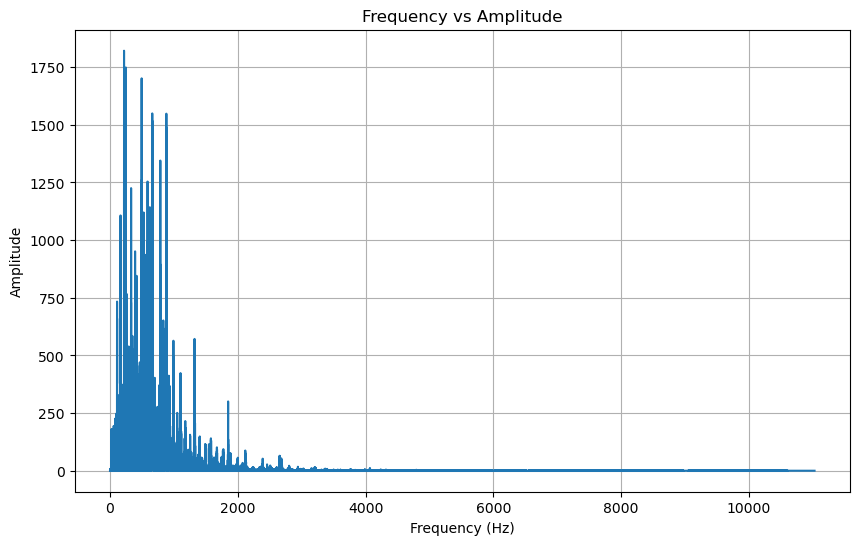

In [8]:
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import numpy as np
import librosa as lb
import librosa.display

# Load the audio file
audio_path = '/Users/manny/Computational Methods In Physics/Final Project/Fur_Elise02.wav'  # Replace with the path to your audio file
y, sr = librosa.load(audio_path)

# Perform FFT to get the frequency domain representation
fft_result = np.fft.fft(y)
magnitude_spectrum = np.abs(fft_result)[:len(fft_result)//2]  # Take only the positive frequencies
frequencies = np.fft.fftfreq(len(fft_result), 1/sr)[:len(fft_result)//2]

# Plot frequency vs amplitude
plt.figure(figsize=(10, 6))
plt.plot(frequencies, magnitude_spectrum)
plt.title('Frequency vs Amplitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

For a time vs time versus amplitude:

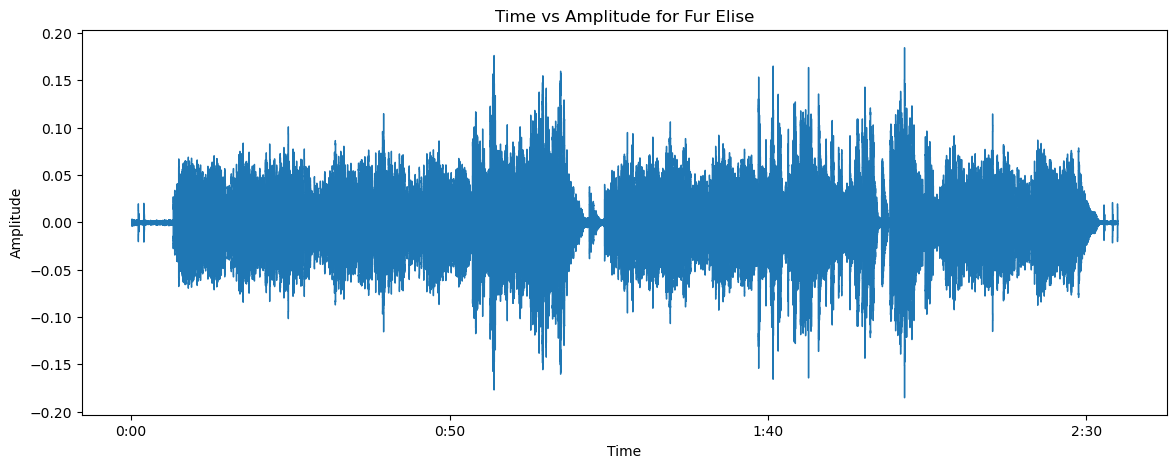

In [12]:
x, sr = librosa.load('/Users/manny/Computational Methods In Physics/Final Project/Fur_Elise02.wav') # line needed to get step 5 to run. DO NOT CHANGE

%matplotlib inline

plt.figure(figsize=(14, 5))
plt.title('Time vs Amplitude for Fur Elise')
plt.xlabel('Time')
plt.ylabel('Amplitude')
librosa.display.waveshow(x, sr=sr)